## Data Mining: Programming Project WS 2020

## Graph Property Prediction

This is part 2 of the programming assignment, covering the classification of sample graph datasets. This first document covers question (b).

## Group 9 members: 

responsible for task (b):
- MAXIMILIAN FAISSNER
- LAURA JAHN

responsible for task (c+d):
- RAPHAEL BEDNARSKY
- PETER HUNYADI
- NIKOLA VINKO

Notice: This Jupyter notebook is fully executable with all supplied files. For improved readability, all imports & functions are below - these cells need to be executed first.


---
## (b) Classification & Clustering of the Enzymes Dataset

In the exploratory data analysis presented in part 1 of this project, we already covered many key facts about the enzyme dataset. Originally released on 2005 by Borgwardt et al., the dataset contains 600 enzymes as individual graphs. These proteins are split into 6 groups (called EC classes) which 100 members each.

The visualization below is from 6 selected dimensions of gram matrix of the dataset, computed with the Weisfeiler-Lehman kernel (wl5).      

It can be seen that often enzymes of the same EC class are grouped together in some dimensions, but due to the biological nature of proteins there is never a clear separation of classes - cross-contamination is alway present.

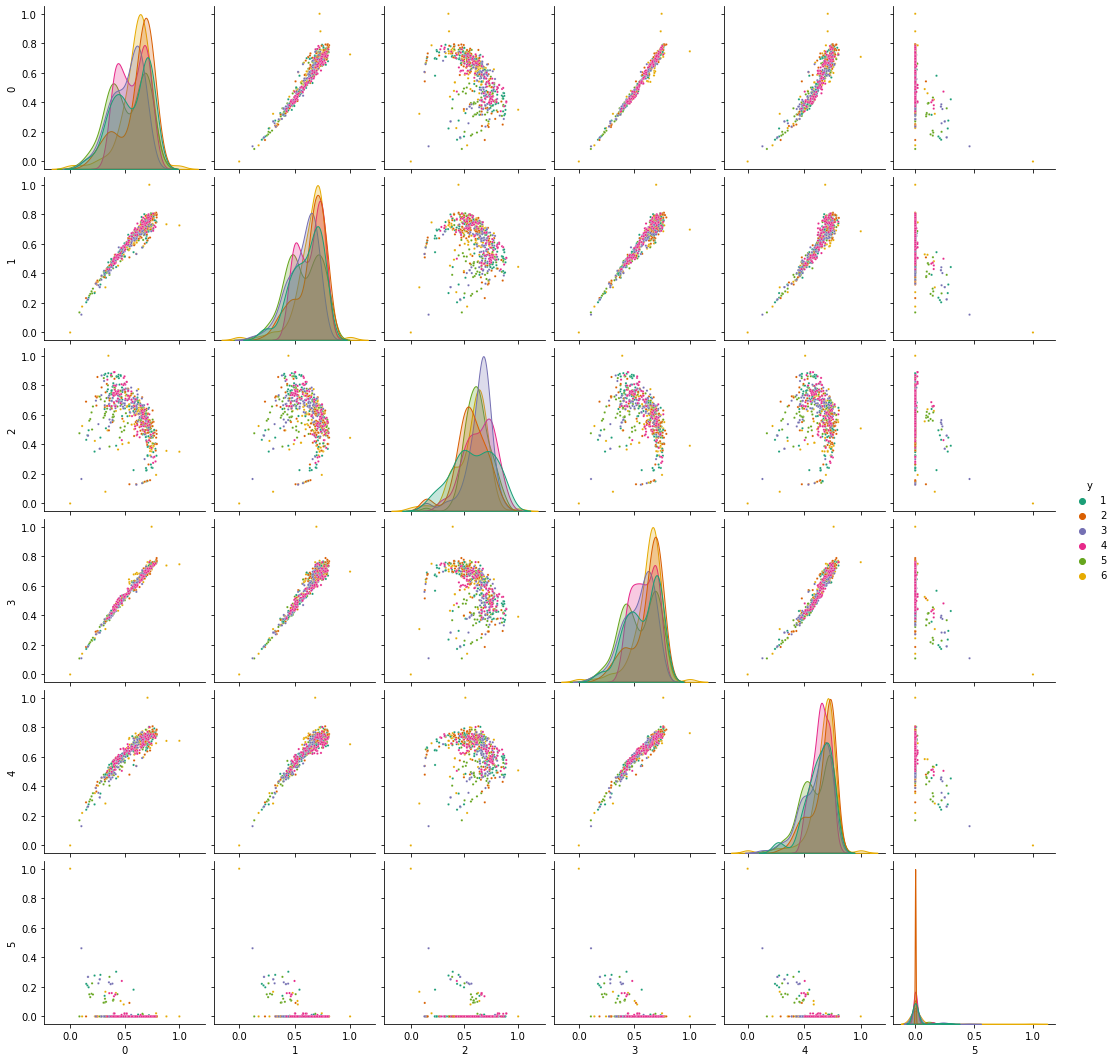

In [190]:
pd_input = pd.DataFrame(gram_matrix_wl5[:,5:11]) # this is normalized (auxiliarymethods function)
pd_input["y"] = classes # true labels as coloring
sns_plot = sns.pairplot(pd_input, vars=pd_input.columns[:-1], hue="y", palette="Dark2", plot_kws={"s": 5})

## Classification with baseline kernels

The primary task here is to relate our findings from clustering experiments (which were also partly performed in part 1) to c-SVM predictions of trained classifiers with true labels, as described in the original paper. First, we will take a look at the baseline kernels in the TUdataset collection, and compare our computed results with those presented in the original papers. 

For the enzymes daaset, the optimal assignment Weisfeiler-Lehman kernel should have a classification accuarcy of about 60%:

<img src="enzymes_wl_oa.png" width="700" height="200" />

Source: On Valid Optimal Assignment Kernels and Applications to Graph Classification, Nils M. Kriege, Pierre-Louis Giscard, Richard C. Wilson, NIPS 2016 https://papers.nips.cc/paper/6166-on-valid-optimal-assignment-kernels-and-applications-to-graph-classification.pdf

Original paper for Weisfeiler-Lehman kernel: http://www.jmlr.org/papers/volume12/shervashidze11a/shervashidze11a.pdf     
        

## Validation of classification accuarcies

Gram matrices were regenerated with the help of functions in the __TUdataset package__. These were then normalized with the supplied function (auxiliaryfunctions package). The accuracy computation is based on a K-fold-cross validation approach with c-SVM, as described in the paper. The supplied function (kernel_svm_evaluation) yielded the following results:

In [18]:
all_matrices = [gram_matrix_wl1, gram_matrix_wl2, gram_matrix_wl3, gram_matrix_wl4, gram_matrix_wl5]
num_reps = 10
accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)
print (f"WL 1-5 kernel accuracy: {accuracy:2.2f} ± {std_10:2.2f} (standard deviations of 10-CV runs)")

WL 1-5 kernel accuracy: 50.58 ± 1.00 (standard deviations of 10-CV runs)


In [19]:
all_matrices = [gram_matrix_oa]
num_reps = 10
accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)
print (f"WL optimal assignment kernel accuracy: {accuracy:2.2f} ± {std_10:2.2f} (standard deviations of 10-CV runs)")

WL optimal assignment kernel accuracy: 54.78 ± 1.06 (standard deviations of 10-CV runs)


## Visualization of Kernel accuracies

In order to get a deeper understanding of the classification result, heatplots were generated as visualization. 

- y-axis: 6 EC-classes
- x-axis: 100 enzymes per row

This simple visualization seems practical for this setting. The following sample plot corresponds to an ideal clustering / ideal classification result, where each row only contains a single class:


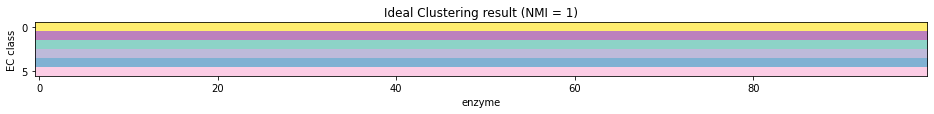

In [93]:
heatmap_labels(classes, "Ideal Clustering result (NMI = 1)")

### Classification performance as heatmap 1/2

Shown below is a visual representation of the c-SVM classification results (one run). An ideal classification with 100% accuracy should be the same as above. The result below corresponds to the ~55% accuracy of the optimal assignment kernel. This gives us a good indication of the classification performance per EC-class.

The kernel evaluation function was adjusted (see function below) to also return predicted labels from one of the cross-validation runs. 

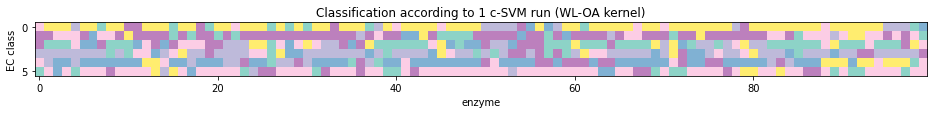

In [91]:
# uses all_matrices as input (e.g. WL_OA)
accuracy, std_10, std_100, pred_labels = custom_kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)
heatmap_labels(pred_labels, "Classification according to 1 c-SVM run (WL-OA kernel)")

### Classification performance as heatmap 2/2

As alternative visualization, all incorrect label predictions can also be coloured differently, as seen below. This plot has now 7 colours, the predominant colour corresponds to wrong label predictions:

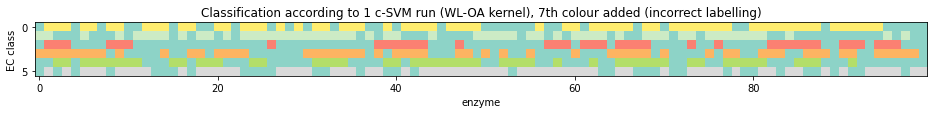

Incorrect classifications: 268


In [172]:
# add 7th colour
pred_labels_adj, pred_labels_n, pred_labels_incorrect = mark_incorrect_as_noise(pred_labels)
heatmap_labels(pred_labels_adj, "Classification according to 1 c-SVM run (WL-OA kernel), 7th colour added (incorrect labelling)")
print ("Incorrect classifications:", pred_labels_incorrect)

EC-Classes 1 and 6 show the best prediction performance. On the contrary, class 3 seems to be hard to predict. 

In the following, these results will be compared with clustering results.

## Clustering results
#### (Review of part 1 of programming assignment & new results)

In __part 1__ of this programming assignment (EDA), several dimensionality reduction techniques were tested in conjunction with various clustering methods. In all tested instances, the clustering __performance was lackluster__. Since additional preprocessing (PCA) had mostly adverse results, we will focus in the following on results only obtained by clustering directly the gram matrix. 

For clustering metrics, since we have access to true labels, only the normalized mutual information score (NMI) is shown. 

#### K-means / Nr-K-means

First, clustering results from K-means are presented. Notice that in the EDA part we selected the optimal $k$-value with the elbow-method ($k=10$). In general, we see the same trend for all clustering results: We can detect smaller clusters, but as soon we try to put them into 6 combined clusters, the clustering gets a lot worse. 

In [138]:
# set working matrix and normalize with auxiliarymethods function
# gram = gram_matrix_wl5
gram = gram_matrix_oa

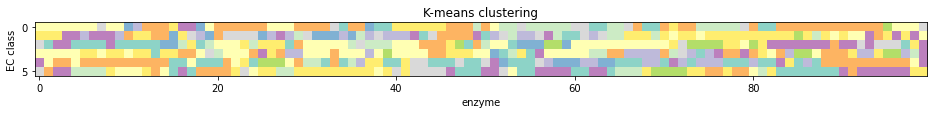

K-Means NMI-score:0.1047


In [104]:
# KMeans no PCA
kmeans = KMeans(n_clusters=10 ,random_state=41).fit(gram)
km_nmi = normalized_mutual_info_score(kmeans.labels_ , classes)
heatmap_labels(kmeans.labels_, "K-means clustering")
print(f"K-Means NMI-score:{km_nmi:.4f}")

Various of the high-dimensional clustering methods were now additionally tested (not tested before in the EDA part). For __NrKmeans__ clustering, the python version was used which supplied for one of the exercise sheets. Various other algorithms were evaluated with ELKI (see below). 

In [111]:
# Nrk-means (k=8 or 10, 3x, 1 noise dimension)
# nrkmeans = NrKmeans(n_clusters=[8,8,1])
nrkmeans = NrKmeans(n_clusters=[10,10,1])
nrkmeans.fit(gram)

found solution with: 494.6840944417056 (current best is -1)
found solution with: 502.87478360337053 (current best is 494.6840944417056)
found solution with: 502.25140696030144 (current best is 494.6840944417056)
found solution with: 492.87046157092976 (current best is 494.6840944417056)
found solution with: 495.1426397057521 (current best is 492.87046157092976)
found solution with: 496.03658448926814 (current best is 492.87046157092976)
found solution with: 515.3654756210784 (current best is 492.87046157092976)
found solution with: 497.61307608140396 (current best is 492.87046157092976)
found solution with: 503.415740339009 (current best is 492.87046157092976)
found solution with: 495.99791710968407 (current best is 492.87046157092976)


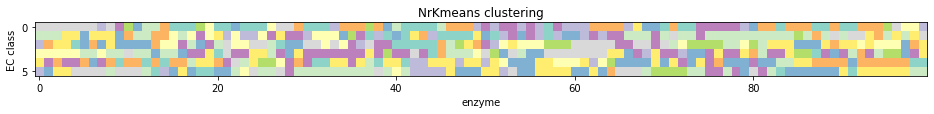

K-Means NMI-score:0.0907


In [146]:
heatmap_labels(nrkmeans.labels[1], "NrKmeans clustering")
km_nmi = normalized_mutual_info_score(nrkmeans.labels[1] , classes)
print(f"K-Means NMI-score:{km_nmi:.4f}")

#### DBSCAN and related algorithms:

For DBSCAN, selecting a low value for $min$_$samples=2$ allows us to achieve much better clustering results as presented in the EDA part:

(notice: pixels in teal represent enzymes classified as noise)

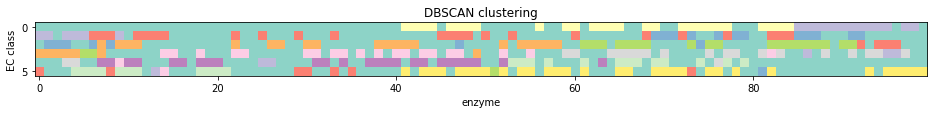

DBSCAN NMI-score:0.3535


In [145]:
# DBSCAN
dbscan_clustering = DBSCAN(min_samples=2, eps=1.1)
dbscan_clustering.fit(gram)
dbscan_nmi = normalized_mutual_info_score(dbscan_clustering.labels_, classes)
heatmap_labels(dbscan_clustering.labels_, "DBSCAN clustering")
print(f"DBSCAN NMI-score:{dbscan_nmi:.4f}")

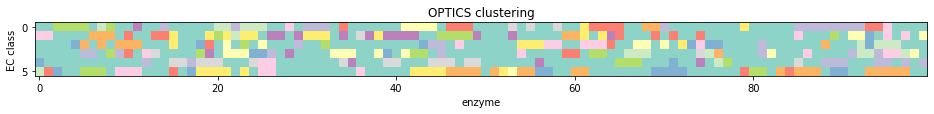

OPTICS NMI-score:0.2670


In [163]:
# OPTICS
optics_clustering = OPTICS(min_samples=4, xi=.001, min_cluster_size=.005) # wl5
# optics_clustering = OPTICS(min_samples=5, xi=.001, min_cluster_size=.01)
optics_clustering.fit(gram)
optics_nmi = normalized_mutual_info_score(optics_clustering.labels_, classes)
heatmap_labels(optics_clustering.labels_, "OPTICS clustering")
print(f"OPTICS NMI-score:{optics_nmi:.4f}")

Results for PREDECON are shown below as representative subspace clustering. These results were generated with ELKI (input parameters: $epsilon=2.5, minpts=2, delta=0.1$), which generates a .csv file with label predictions. A script was written to parse these output files (see below).

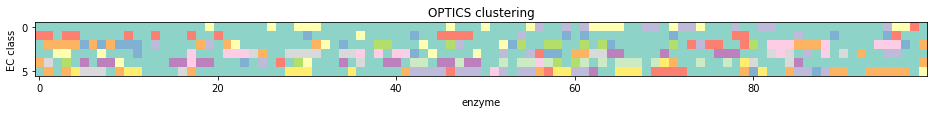

PREDECON NMI-score:0.2408


In [168]:
# PREDECON - read results generated by ELKI
matrix = "./gram_matrix_oa.csv"
matrix = np.loadtxt(matrix, delimiter=",")  
input_file = "./predecon_result_oa_kernel.csv"
predecon_labels = elki_parser(input_file)

predecon_nmi = normalized_mutual_info_score(predecon_labels, classes)
heatmap_labels(predecon_labels, "OPTICS clustering")
print(f"PREDECON NMI-score:{predecon_nmi:.4f}")

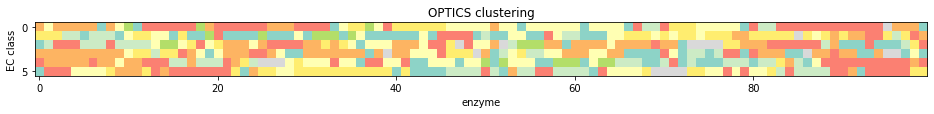

PREDECON NMI-score:0.0721


In [188]:
agg_clustering = AgglomerativeClustering(n_clusters=8, linkage="ward")
agg_clustering.fit(gram)

agg_nmi = normalized_mutual_info_score(agg_clustering.labels_, classes)
heatmap_labels(agg_clustering.labels_, "OPTICS clustering")
print(f"PREDECON NMI-score:{agg_nmi:.4f}")

#### Results Clustering

Among all tested clustering algorithms, __DBSCAN__ performed the best. Any variant (subspace or not) performed worse than the original algorithm. 

## Relation c-SVM Classification and Clustering

As repetition, the DBSCAN clustering result and classification result is plotted below:

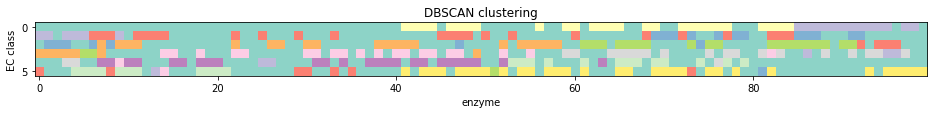

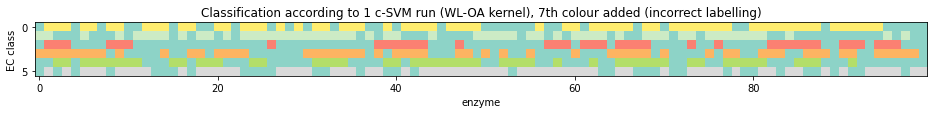

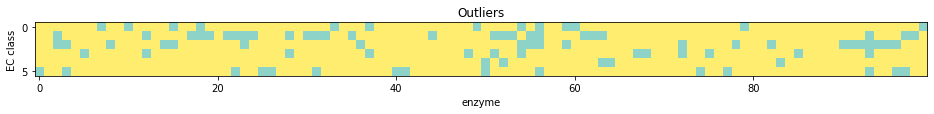

In [210]:
# DBSCAN plot
heatmap_labels(dbscan_clustering.labels_, "DBSCAN clustering")
print()
# classification plot with added 7th colour
heatmap_labels(pred_labels_adj, "Classification according to 1 c-SVM run (WL-OA kernel), 7th colour added (incorrect labelling)")
# outliers as calculated in the EDA part
print()
heatmap_labels(outlier_list, "Outliers")

When comparing clustering and classification results, we can find some enzymes which can't be classified easily which then become noise points during clustering. In general, the graph kernels need further improvement to draw any meaningful results here. 

However, we could not find any relation between noise points and classification/clustering results. This may be due to the method (kernel PCA) which was used to detect noise points (see EDA part). 

## Discussion

Given the fact that clustering finds many smaller subgroups within the EC-classes, it may be beneficial to attempt a fine-grained c-SVM classification with subclasses within the 6 larger classes. Even with better graph kernels, it might be unavoidable to consider this problem from a more hierarchical point of view (adding up smaller subclasses in a tree-like structure). 

For clustering, it seems that DBSCAN is sufficient as algorithm to detect smaller sub-clusters. A proper hyperparameter optimization could lead to even better results. In general, it seems unavoidable that a part of the samples has no cluster structure, given the clustering accuracy as presented above. Even with better kenels, due to the biological nature we expect that many outliers exist and cannot be classified/clustered properly. 

Notice that if the dataset would be in orders of magnitudes larger, DBSCAN might not be sufficient. In any case, the choice of a properly working subspace clustering algorithm is non-trivial - more work would be required here to properly assess if any of the presented algorithms during the lectures are actually beneficial. 



---

# (d) Results & Discussion: Improved Kernels 

(calculation of results, which will be presented in part 2 of the video series)

DBSCAN NMI-score:0.4036


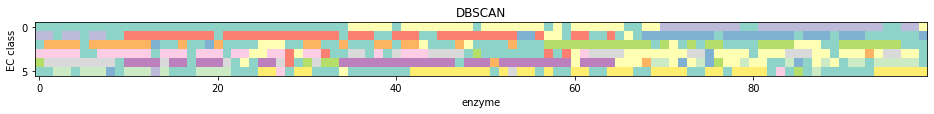

In [233]:
# new kernel
# ENZYMES_gram_matrix_hyperkernel_v1.csv
gram = gram_matrix_new

# DBSCAN
dbscan_clustering = DBSCAN(min_samples=2, eps=1.41)
dbscan_clustering.fit(gram)
dbscan_nmi = normalized_mutual_info_score(dbscan_clustering.labels_, classes)
heatmap_labels(dbscan_clustering.labels_, "DBSCAN", "hyperkernel_v1.png")
print(f"DBSCAN NMI-score:{dbscan_nmi:.4f}")

DBSCAN NMI-score:0.3433


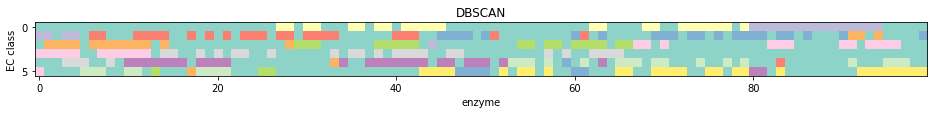

In [234]:
# new kernel
# ENZYMES_gram_matrix_hyperkernel_v2.csv
gram = gram_matrix_new_2

# DBSCAN
dbscan_clustering = DBSCAN(min_samples=2, eps=1.5)
dbscan_clustering.fit(gram)
dbscan_nmi = normalized_mutual_info_score(dbscan_clustering.labels_, classes)
heatmap_labels(dbscan_clustering.labels_, "DBSCAN", "hyperkernel_v2.png")
print(f"DBSCAN NMI-score:{dbscan_nmi:.4f}")

---
## Imports & helper functions below

In [105]:
import os
import torch
import numpy as np
from copy import deepcopy
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt
import seaborn as sns

from nrkmeans import NrKmeans # requires sklearn 0.22 ... had to downgrade

from scipy.sparse import save_npz
from scipy.sparse import load_npz
from sklearn.decomposition import KernelPCA, TruncatedSVD, PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN

from sklearn.metrics import normalized_mutual_info_score, pairwise_distances
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, svm, metrics

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
# we set our working dir to the tud_benchmark directory, here are the necessary 
# python files for the include below
os.chdir("./tudataset/tud_benchmark")
import auxiliarymethods
from auxiliarymethods import datasets as dp
from auxiliarymethods import auxiliary_methods as aux
from auxiliarymethods import kernel_evaluation
from auxiliarymethods import reader

dataset = "ENZYMES"
classes = dp.get_dataset(dataset) # this downloads the datasets and stores a list of integers with the true labels
G = reader.tud_to_networkx(dataset)
os.chdir("../..")

In [ ]:
# the next cell computes baseline kernels - no need to rexecute this cell

# include the compiled Python bindings:
os.chdir("./tudataset/tud_benchmark")
import kernel_baselines as kb
os.chdir("../..")

use_edge_labels = False
dataset = "ENZYMES"

os.chdir("./tudataset/tud_benchmark")
for use_labels in [True, False]:# Except IMDB-BINARY

        if use_labels:
            base_path = os.path.join("kernels","node_labels")
        else:
            base_path = os.path.join("kernels","without_labels")
            
        print("Start processing data set ", dataset)
        # Download dataset.
        classes = dp.get_dataset(dataset)
        # *Weisfeihler-Lehman*
        print("Start computing Weisfeihler-Lehman gram matrix and vector representations")
        
        iterations = 6 # means just 5...
        
        #0 taking just the nodelabels themselves into account; 
        #1 considers nearest-neighbours, 2 one layer deeper and so on
        for i in range(1, iterations):
            print("Start iteration ", i)
            #Gram Matrix for the Weisfeiler-Lehman subtree kernel
            gram_matrix_wl = kb.compute_wl_1_dense(dataset, i, use_labels, use_edge_labels)
            np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_wl{i}.csv"),
                    gram_matrix_wl,
                    delimiter=";")
            #Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
            vectors_wl = kb.compute_wl_1_sparse(dataset, i, use_labels, use_edge_labels)
            save_npz(os.path.join(base_path,f"{dataset}_vectors_wl{i}.npz"),
                    vectors_wl, compressed=True)               
            
        # *Graphlet kernel*
        print("Start computing Graphlet gram matrix")

        #Gram Matrix for the Graphlet kernel
        gram_matrix_graphlet= kb.compute_graphlet_dense(dataset, use_labels, use_edge_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_graphlet.csv"),
                gram_matrix_graphlet,
                delimiter=";")

        print("Start computing Graphlet vector representation")
        #Sparse Vectors for the Graphlet kernel
        vectors_graphlet = kb.compute_graphlet_sparse(dataset, use_labels, use_edge_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_graphlet.npz"),
                vectors_graphlet, compressed=True)


        print("Start computing Shortest path gram matrix")
        #Gram Matrix for the Shortest path kernel
        gram_matrix_shortestpath = kb.compute_shortestpath_dense(dataset, use_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_shortestpath.csv"),
                gram_matrix_shortestpath,
                delimiter=";")

        print("Start computing Shortest path vector representation")
        #Sparse Vectors for the Shortest path kernel
        vectors_shortestpath = kb.compute_shortestpath_sparse(dataset, use_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_shortestpath.npz"),
                vectors_shortestpath, compressed=True)
        
        # Weisfeiler-Lehman optimal assignment kernel
        # *WL-OA* # https://chrsmrrs.github.io/datasets/docs/evaluation/
        print("Start WL OA")
        gram_matrix_oa = kb.compute_wloa_dense(dataset, 6, use_labels, use_edge_labels)    
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_oa.csv"),
                gram_matrix_oa,
                delimiter=";")
                   
os.chdir("../..")

In [211]:
# since we don't want to regenerate the baseline kernels all the time, we're reading gram-matrices from a csv file:

#Gram Matrix (G=V^T*V) for the Weisfeiler-Lehman subtree kernel
kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl1.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl1 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl2.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl2 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl3.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl3 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl4.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl4 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl5.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl5 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_oa.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_oa = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/without_labels/ENZYMES_gram_matrix_hyperkernel_v1.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_new = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/without_labels/ENZYMES_gram_matrix_hyperkernel_v2.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_new_2 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

In [97]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from collections import defaultdict

# this function additionally outputs predicted labels
def custom_kernel_svm_evaluation(all_matrices, classes, num_repetitions=10,
                          C=[10 ** 3, 10 ** 2, 10 ** 1, 10 ** 0, 10 ** -1, 10 ** -2, 10 ** -3], all_std=False):
    # Acc. over all repetitions.
    test_accuracies_all = []
    # All acc. over all folds and repetitions.
    test_accuracies_complete = []
    
    return_list = defaultdict(list)

    for i in range(num_repetitions):
        # Test acc. over all folds.
        test_accuracies = []
        kf = KFold(n_splits=10, shuffle=True)

        for train_index, test_index in kf.split(list(range(len(classes)))):
            # Determine hyperparameters
            train_index, val_index = train_test_split(train_index, test_size=0.1)
            best_val_acc = 0.0
            best_gram_matrix = all_matrices[0]
            best_c = C[0]

            for gram_matrix in all_matrices:
                train = gram_matrix[train_index, :]
                train = train[:, train_index]
                val = gram_matrix[val_index, :]
                val = val[:, train_index]

                c_train = classes[train_index]
                c_val = classes[val_index]

                for c in C:
                    clf = SVC(C=c, kernel="precomputed", tol=0.001)
                    clf.fit(train, c_train)
                    val_acc = accuracy_score(c_val, clf.predict(val)) * 100.0
                    
#                     print (val_index)
                    return_list[tuple(val_index)].append(clf.predict(val))
#                     for v in val_index:
#                         return_list[v].append(clf.predict(val))

                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_c = c
                        best_gram_matrix = gram_matrix

            # Determine test accuracy.
            train = best_gram_matrix[train_index, :]
            train = train[:, train_index]
            test = best_gram_matrix[test_index, :]
            test = test[:, train_index]

            c_train = classes[train_index]
            c_test = classes[test_index]
            clf = SVC(C=best_c, kernel="precomputed", tol=0.001)
            clf.fit(train, c_train)
            best_test = accuracy_score(c_test, clf.predict(test)) * 100.0

            test_accuracies.append(best_test)
            if all_std:
                test_accuracies_complete.append(best_test)
        test_accuracies_all.append(float(np.array(test_accuracies).mean()))

    # postprocessing of predicted labels
    pred_labels = defaultdict(list)
    for l in return_list:
        for i in range(len(l)):        
            n = l[i]
            v = return_list[l][0][i]
            pred_labels[n].append(v)
            
    pred_labels_2 = [0]*600
    for y in pred_labels:
        pred_labels_2[y] = pred_labels[y][0]
        
    if all_std:
        return (np.array(test_accuracies_all).mean(), np.array(test_accuracies_all).std(),
                np.array(test_accuracies_complete).std(), pred_labels_2)
    else:
        return (np.array(test_accuracies_all).mean(), np.array(test_accuracies_all).std())
    
    
def mark_incorrect_as_noise(pred_labels):
    
    classes_to_plot = pred_labels
    # split into 6x100 matrix
    heatmap = np.array([classes_to_plot[0:100], classes_to_plot[100:200], classes_to_plot[200:300],\
                        classes_to_plot[300:400], classes_to_plot[400:500], classes_to_plot[500:600]])
    
    noise = defaultdict(list)
    predominant_label = [0]*6
    for i in range(1,7):
        o = []
        for j in range(6):
            occurrence = np.count_nonzero(heatmap[j] == i)
            o.append(occurrence)
        
        o = np.argmax(o)
        predominant_label[o] = i
    
    result_list = []  
    incorrect = 0
    
    for n, i in enumerate(heatmap):
        for k, j in enumerate(i):
            if j != predominant_label[n]:
                result_list.append(-1)
                noise[n].append(-1)
                incorrect += 1
            else:
                result_list.append(j)    
         
    
    return result_list, noise, incorrect


In [38]:
accuracy, std_10, std_100, y = custom_kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)
print (f"WL optimal assignment kernel accuracy: {accuracy:2.2f} ± {std_10:2.2f} (standard deviations of 10-CV runs)")

WL optimal assignment kernel accuracy: 54.87 ± 1.12 (standard deviations of 10-CV runs)


In [232]:
# heatmap visualization function
def heatmap_labels(pred_labels, set_title="Clustering Heatmap", save=None):
    classes_to_plot = pred_labels
    # split into 6x100 matrix
    heatmap = np.array([classes_to_plot[0:100], classes_to_plot[100:200], classes_to_plot[200:300],\
                        classes_to_plot[300:400], classes_to_plot[400:500], classes_to_plot[500:600]])

    plt.figure(num=None, figsize=(16, 4), facecolor='w', edgecolor='k')
    plt.imshow(heatmap, cmap='Set3', interpolation='nearest')
    plt.title(set_title)
    plt.ylabel('EC class')
    plt.xlabel('enzyme')
    if save:
        plt.savefig(save, dpi=120)
    else:
        plt.show()    
# heatmap_labels(classes, "Ideal Clustering result with NMI = 1")

In [164]:
# function to parse elki clustering outputs
def elki_parser(filename):    
    current_cluster = -1 # the first cluster gets incremented to cluster 0    
    labels = []
    processed = []    
    with open(filename, "r") as f:        
        for line in f:
            line = line.strip()
            if len(line)==0:
                continue                
            if "Cluster: Cluster" in line or "Cluster: Noise" in line:
                # new cluster segment
                current_cluster += 1
                labels.append([])
#                 print ("new")            
            if line[0] == "#":                                                
                continue                
            if "ID=" in line:
                line = line.split()[1:]
                line = np.array([float(i) for i in line])
                #print (current_cluster, line)
#                 print (line in matrix)
                row = np.where((matrix == line).all(axis=1))
                
                for i in row[0]:
                    if i in processed: 
                        continue
                    labels[-1].append(i)
                    processed.append(i)
    
    processed = set(processed)
    return_labels = [0]*len(processed)    
    for i, k in enumerate(labels):
        for j in k:
#             print (j, i)
            return_labels[j] = i    
    return return_labels

In [194]:
# Kernel PCA
kpca = KernelPCA(n_components=100, kernel="precomputed")
reduced_kpca= kpca.fit_transform(gram)

# lets investiage the outliers in kPCA
reduced_kpca_2d = pd.DataFrame(data = reduced_kpca[:, 0:2], columns = ["PC1","PC2"])
index_kpca = reduced_kpca_2d.index
outliers = reduced_kpca_2d[(reduced_kpca_2d["PC2"] > 0.2) & (reduced_kpca_2d["PC1"] < 0.5) ]
print("Num of outliers: ", len(outliers.index))

Num of outliers:  28


/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


In [207]:
# this cell computes a list of outliers, as presented & described in the EDA part

# node count distribution of the graphs
threshold_nodes= [10, 52]
node_lengths = [graph.number_of_nodes() for graph in G ]

# edge count distribution of the graphs
threshold_edges= [22, 100]
edge_lengths = [graph.number_of_edges() for graph in G ]

# lets make some cutoffs to remove some extreme data points
G_filtered = []
indices_true = []

outlier_list = [0]*600

for graph, index in zip(G, range(0, len(G))):
    if threshold_nodes[0] < graph.number_of_nodes() < threshold_nodes[1] \
    and threshold_edges[0] < graph.number_of_edges() < threshold_edges[1] \
    and index not in outliers.index: #remove this line if you dont want to filter out the outliers
        G_filtered.append(graph)
        indices_true.append(index)
        outlier_list[index] = 1
        
indices_true = np.array(indices_true)
classes_filtered = classes.copy()
classes_filtered = classes_filtered[indices_true] #subsetting the label list to remove OL
print("Size of filtered data: ",len(G_filtered))

Size of filtered data:  507
